In [1]:
datapath = './nonlinear_superlearn_datasets/'

import autograd.numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

---
# Some Handy Tools

In [2]:
from autograd import grad
from autograd import hessian
def newtons_method(g, max_its, w):
    gradient = grad(g)
    hess = hessian(g)
    epsilon = 1e-7
    
    weight_his = [w]
    cost_his = [g(w)]
    for k in range(max_its):
        grad_eval = gradient(w)
        hess_eval = hess(w)
        
        hess_eval.shape = (int(np.size(hess_eval)**0.5),
                           int(np.size(hess_eval)**0.5))
        A = hess_eval + epsilon*np.eye(w.size)
        b = grad_eval
        w = np.linalg.solve(A, np.dot(A,w)-b)
        weight_his.append(w)
        cost_his.append(g(w))
    return weight_his, cost_his

def gradient_descent(g, max_its, w):
    gradient = grad(g)
    weight_his = [w]
    cost_his = [g(w)]
    for k in range(max_its):
        grad_eval = gradient(w)
        w = w - 0.1 * grad_eval
        weight_his.append(w)
        cost_his.append(g(w))
    return weight_his, cost_his

---

# 10.4

(a)

$$
f(y) = log(y)
$$

(b)

In [3]:
# import the dataset
csvname = datapath + 'transistor_counts.csv'
data = np.asarray(pd.read_csv(csvname,header = None))
x = data[:,0]
x.shape = (len(x),1)
y = data[:,1]
y.shape = (len(y),1)
x = x.T
y = y.T
print(x.shape, y.shape)


def feature_transforms(a):
    f = np.log2(a.T)
    return f.T

def norm(x):
    mu = np.sum(np.array(x), 1) / float(x.shape[1])
    tmp = np.apply_along_axis(lambda x : x - mu, 0, x)
    sigma = np.sqrt(np.sum(np.apply_along_axis(lambda x : x - mu, 0, x)**2, 1) / float(x.shape[1]))
    x = np.apply_along_axis(lambda x : (x - mu) / sigma, 0, x)
    return x

def model(x, w):
    x = norm(x)
    a = w[0] + np.dot(x.T, w[1:])
    return a.T

def least_squares(w):
    cost = np.sum((model(x, w) - feature_transforms(y))**2)
    return cost/float(y.size)

def train():
    theta = np.ones((2, 1))
    weight_his, _ = newtons_method(least_squares, 1000, theta)
    print(weight_his[-1])
    return weight_his[-1]

weight = train()

(1, 85) (1, 85)
[[23.95458172]
 [ 6.61301065]]


Now we plot the result

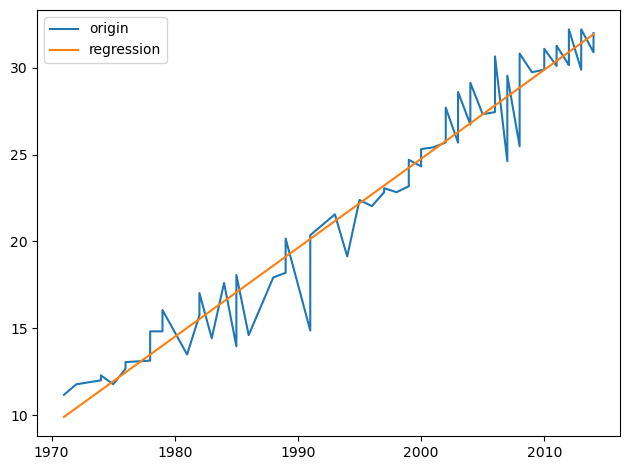

In [4]:
plt.plot(x.T, np.log2(y.T),label='origin')
plt.plot(x.T, model(x, weight).T, label='regression')
plt.legend()

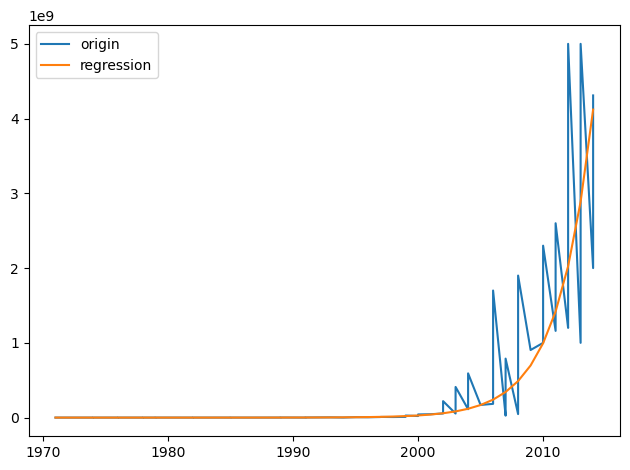

In [5]:
plt.plot(x.T, y.T, label='origin')
plt.plot(x.T, np.power(2, model(x, weight).T), label='regression')
plt.legend()

# 10.8

In [6]:
csvname = datapath + 'diagonal_stripes.csv'
data = np.loadtxt(csvname, delimiter=',')

x = data[:2,:]
y = data[2:,:]

print(np.shape(x))
print(np.shape(y))


(2, 300)
(1, 300)


In [7]:
def feature_transforms(x, w):
    #print(x.shape, w.shape)
    f = np.sin(w[0] + np.dot(x.T, w[1:]))
    return f.T

def classifer(x, theta):
    x = norm(x)
    f = feature_transforms(x, theta[0])
    a = theta[1][0] + np.dot(f.T, theta[1][1])
    return a

def softmax(w):
    global y
    y = norm(y)
    cost = np.sum(np.log(1+np.exp(-y*classifer(x,w))))
    return cost/float(np.size(y))

def train():
    theta = 3 * np.ones((2, 3))
    weight_his, _ = gradient_descent(softmax, 1000, theta)
    return weight_his[-1]

weight = train()
print(weight)

[[1.1529747  2.30704686 3.5755075 ]
 [0.02487078 6.00924647 3.        ]]


In [8]:
mis_classified = np.sum(np.apply_along_axis(lambda x : 1 if x < 0 else 0, 0, (y*classifer(x, weight))))
print(f"There are {mis_classified} mismatches in total")

There are 0 mismatches in total


# 11.1

the costs for training

In [9]:
csvname = datapath + 'noisy_sin_sample.csv'

data = np.loadtxt(csvname, delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

print(np.shape(x))
print(np.shape(y))

p = np.random.permutation(len(x))
x = x[p]
y = y[p]
training_set = zip(x[0][0:14], y[0][0:14])
testing_set = zip(x[0][14:], y[0][14:])

def train():
    weights = []
    costs = []
    x, y = zip(*training_set)
    x = np.array(x).reshape(1, -1)
    y = np.array(y).reshape(1, -1)
    #x, y = norm(x), norm(y)
    #print(x, y)
    for cap in range(1, 9):
        w = np.random.rand(cap)   
        def model(x, w):
            f = 0
            for i in range(cap):
                f += (x**i) * w[i]
            return f

        def least_squares(w):
            #print(x.shape, y.shape)
            cost = np.sum((model(x, w) - y)**2) + 1e-4 * np.dot(w.T, w)
            return cost/float(y.size)
              
        weight, cost = newtons_method(least_squares, 1000, w)
        weights.append(weight[-1])
        costs.append(cost[-1])
    return weights, costs

weights, training_costs = train()
#print(weights)
print(training_costs)

(1, 21)
(1, 21)
[0.5865592621267671, 0.17838349358101516, 0.16647910149072853, 0.06861344209078832, 0.06236262571112933, 0.06213319351386922, 0.059816576616678364, 0.05749933228844946]


the costs for testing:

In [10]:
def test():
    costs = []
    x, y = zip(*testing_set)
    x = np.array(x).reshape(1, -1)
    y = np.array(y).reshape(1, -1)
    #x, y = norm(x), norm(y)
    #print(x, y)
    for cap in range(1, 9):
        w = weights[cap-1]   
        def model(x, w):
            f = 0
            for i in range(cap):
                f += (x**i) * w[i]
            return f

        def least_squares(w):
            #print(x.shape, y.shape)
            cost = np.sum((model(x, w) - y)**2) + 1e-4 * np.dot(w.T, w)
            return cost/float(y.size)
              
        cost = least_squares(w)
        costs.append(cost)
    return costs

testing_costs = test()
print(testing_costs)

[0.34371279440867947, 0.13844026953296212, 0.2577016704043737, 0.07282252796081044, 0.03250076514833235, 0.04082709557853869, 0.06302721657998811, 0.07458974280264598]


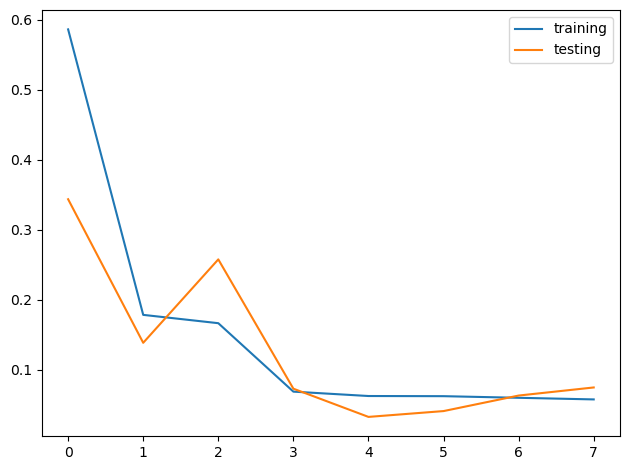

In [11]:
cap = np.array([i for i in range(8)])
plt.plot(cap, training_costs, label='training')
plt.plot(cap, testing_costs, label='testing')
plt.legend()

We can see that it performs best at M=4

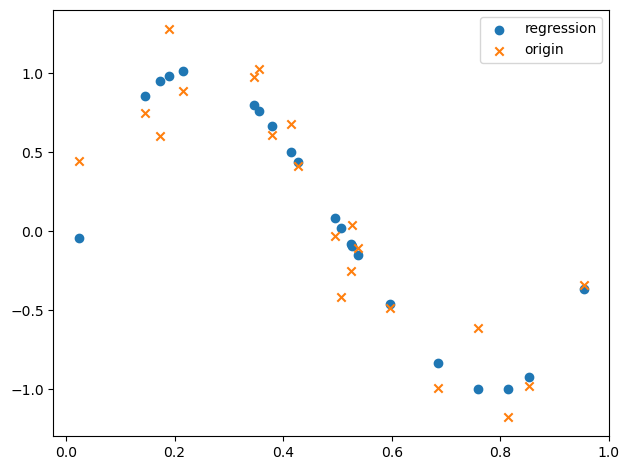

In [12]:
def model(x, w):
    f = 0
    for i in range(4):
        f += (x**i) * w[i]
    return f

plt.scatter(x.T, model(x, weights[3]).T, label='regression')
plt.scatter(x.T, y.T, marker='x', label='origin')
plt.legend()

# 11.3

In [13]:
csvname = datapath + 'new_circle_data.csv'
data = np.loadtxt(csvname, delimiter = ',')

x = data[:-1,:]
y = data[-1:,:] 


print(np.shape(x))
print(np.shape(y))

(2, 99)
(1, 99)


In [14]:
training_set = np.vstack((x[:, 0:66], y[:,0:66]))
testing_set = np.vstack((x[:, 66:], y[:, 66:]))
def train(m=30):
    x, y = np.vsplit(training_set, np.array([2]))
    x = np.array(x)
    y = np.array(y)
    weights = []
    w = np.random.rand(m,4)
    costs = []
    
    def model(x, theta, cap):
        if (cap==0):
            return 0
        a = np.tanh(theta[cap-1][0] + np.dot(x.T, theta[cap-1][1:3]))
        f = np.dot(a, theta[cap-1][3])
        return model(x, theta, cap-1) + f
    
    for cap in range(1, 31):
        
        def softmax(w):
            cost = np.sum(np.log(1+np.exp(-y*model(x, w, cap))))
            return cost/float(np.size(y))

        weight, cost = gradient_descent(softmax, 100, w)
        weights.append(weight[-1])
        costs.append(cost[-1])
        assert (not np.array_equiv(weight[-1], w))
        w = weight[-1]
    return weights, costs

weights, costs = train()

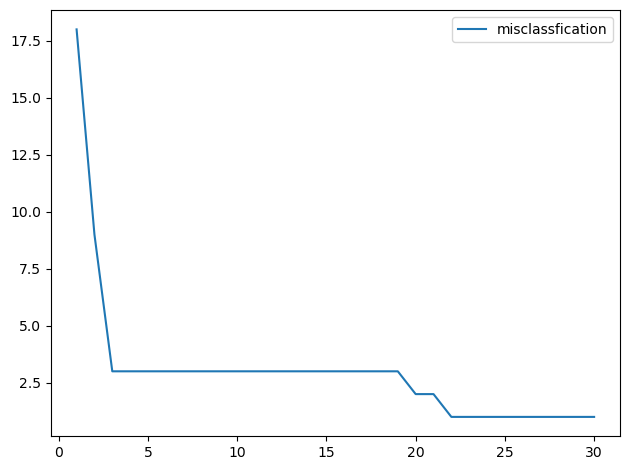

In [15]:
#print(weights)
def test(m=30):
    x, y = np.vsplit(testing_set, np.array([2]))
    miss = []
    
    def model(x, theta, cap):
        if (cap==0):
            return 0
        a = np.tanh(theta[cap-1][0] + np.dot(x.T, theta[cap-1][1:3]))
        f = np.dot(a, theta[cap-1][3])
        return model(x, theta, cap-1) + f
    
    for cap in range(1, 31):
        #print(model(x, weights[cap-1],cap))
        m = np.sum(np.apply_along_axis(lambda x : 1 if x < 0 else 0, 0, (y*model(x, weights[cap-1],cap))))
        miss.append(m)
    return miss

plt.plot(range(1, 31), test(30), label='misclassfication')
plt.legend()